# Depth estimation of mono-camera images for Visual SLAM 

In [5]:
# !unzip example_dataset.zip

In [1]:
import tensorflow as tf
import keras
from keras.layers import Conv2D, UpSampling2D, Concatenate, Dense, BatchNormalization, Dropout, MaxPool2D, Input
from keras.models import Model
from keras.applications import ResNet50
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

# Let's try to create an Autoencoder network (UNET)

Unet has three parts:
- Downsampling   (skip connection to upsampling)
- Bottleneck
- Upsampling

In [2]:
def down_block(x, filters, kernel_s = (3,3), 
              padding_ = 'same', strides_ = 1, 
              activation_ = 'relu'):

    conv1_layer = Conv2D(filters, 
                        kernel_size=kernel_s, 
                        padding=padding_, 
                        strides=strides_, 
                        activation=activation_)(x)
    x = BatchNormalization()(conv1_layer)
    conv2_layer = Conv2D(filters, 
                        kernel_size=kernel_s, 
                        padding=padding_, 
                        strides=strides_, 
                        activation=activation_)(x)

    pooling_layer = MaxPool2D((2,2), strides=(2,2))(conv2_layer)

    return conv2_layer, pooling_layer

def bottleneck(x, filters, kernel_s = (3,3), 
               padding_ = 'same', strides_ = 1, 
               activation_ = 'relu'):

    conv1_layer = Conv2D(filters, 
                        kernel_size=kernel_s, 
                        padding=padding_, 
                        strides=strides_, 
                        activation=activation_)(x)

    conv2_layer = Conv2D(filters, 
                        kernel_size=kernel_s, 
                        padding=padding_, 
                        strides=strides_, 
                        activation=activation_)(conv1_layer)
    return conv2_layer
  

def up_block(x, skip, filters, kernel_s = (3,3), 
                     padding_ = 'same', strides_ = 1, 
                     activation_ = 'relu'):

    up_sampling_1 = UpSampling2D((2,2))(x)
    concat1 = Concatenate()([up_sampling_1, skip])

    conv1_layer = Conv2D(filters, 
                        kernel_size=kernel_s, 
                        padding=padding_, 
                        strides=strides_, 
                        activation=activation_)(concat1)

    conv2_layer = Conv2D(filters, 
                        kernel_size=kernel_s, 
                        padding=padding_, 
                        strides=strides_, 
                        activation=activation_)(conv1_layer)
    return conv2_layer

def resnet50_model(input_shape):
    inputs = keras.layers.Input(input_shape)

    '''Load pre-trained resnet50 '''
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs) # no classifier layers needed.
    # resnet50.summary()

    ''' Encoder '''
    s1 = resnet50.get_layer("input_1").output          #128
    s2 = resnet50.get_layer("conv1_relu").output        #64, 64  filters
    s3 = resnet50.get_layer("conv2_block3_out").output  #32, 256 filters
    s4 = resnet50.get_layer("conv3_block4_out").output  #16, 512 filters

    ''' Bottleneck '''
    pooling_layer = MaxPool2D((2,2), strides=(2,2))(s4)
    bn = bottleneck(pooling_layer, filters = 1024)

    ''' Decoder '''
    d1 = up_block(bn, s4, 1024)
    d2 = up_block(d1, s3, 512)
    d3 = up_block(d2, s2, 256)
    d4 = up_block(d3, s1, 64)

    outputs = Conv2D(1, kernel_size=(1,1), padding='same', activation='sigmoid')(d4)
    model = keras.models.Model(inputs, outputs)

    return model

model = resnet50_model((128, 128, 3))
model.summary()


model.compile(optimizer='adam', loss='mse')
model.summary()
keras.utils.plot_model(model, show_shapes=True)

94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
_____________________________

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

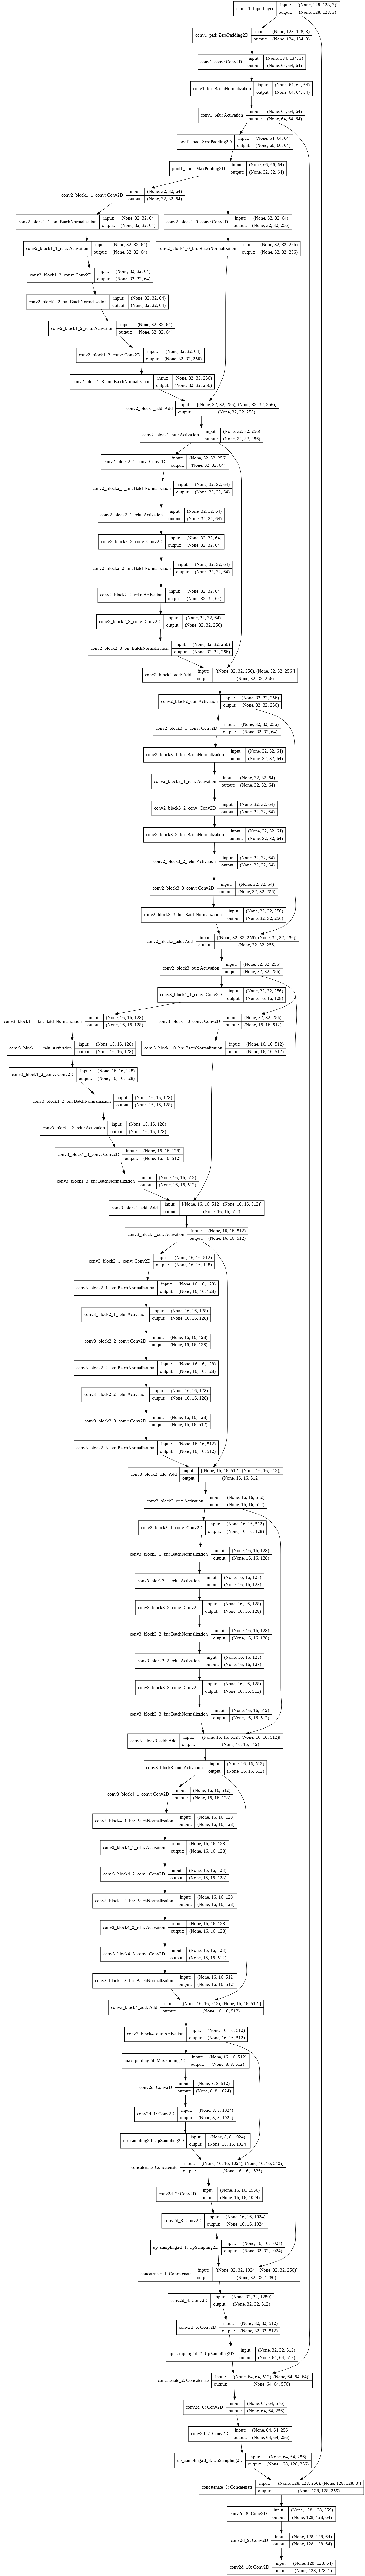

In [6]:
model.compile(optimizer='adam', loss='mse')
model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [7]:
# finish this later on...
import keras
class DataGenerator(keras.utils.Sequence):
  
  def __init__(self, batch_size = 8, image_size = 128):
    self.batch_size = batch_size
    self.image_size = image_size

  def load(self, rgb_file, depth_file):
    image = cv2.imread(rgb_file)
    image = cv2.resize(image, (self.image_size, self.image_size)) # resize...
    depth = cv2.imread(depth_file, -1)
    depth = cv2.resize(depth, (self.image_size, self.image_size)) 

    image_normalized = image/np.max(image)
    depth_normalized = depth/np.max(depth) # double check the depth images!
    return image_normalized, depth_normalized

  def load_all(self, rgb_files, depth_files):
      images = []
      depths = []
      for i in range(len(rgb_files)):
          img, dpth = self.load(rgb_files[i], depth_files[i])
          images.append(img)
          depths.append(dpth)

      return np.array(images), np.array(depths)

In [8]:
# Get file names
rgb_images = os.listdir('rgb/')
rgb_images.sort()
rgb_images = [str('rgb/') + file for file in rgb_images]
depth_images = os.listdir('depth/')
depth_images.sort()
depth_images = [str('depth/') + file for file in depth_images]

test_size = 100
rgb_images_test = rgb_images[:test_size]
depth_images_test = depth_images[:test_size]

rgb_images_train = rgb_images[test_size:]
depth_images_train = depth_images[test_size:]

# Load data:

load_data = DataGenerator()

X_train, y_train = load_data.load_all(rgb_files=rgb_images_train, 
                                      depth_files=depth_images_train)

X_test, y_test = load_data.load_all(rgb_files=rgb_images_test, 
                                  depth_files=depth_images_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(506, 128, 128, 3) (506, 128, 128)
(100, 128, 128, 3) (100, 128, 128)


In [10]:
model.fit(X_train, y_train, batch_size=8, epochs=1, validation_split=0.2)

51/51 [==============================] - 1432s 28s/step - loss: 0.1420 - val_loss: 0.1115


In [11]:
preds = model.predict(X_test)

PREVIOUS UNET SIMPLE MODEL

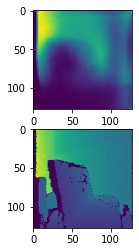

In [ ]:
prds1 = np.reshape(preds[0], newshape=(preds[0].shape[0]*preds[0].shape[1]))
plt.subplot(2,1,1)
plt.imshow(np.reshape(prds1, newshape=(128, 128))*255)
plt.subplot(2,1,2)
plt.imshow(y_test[0]*255)

RESNET ENCODER MODEL RESULTS - not enough training!

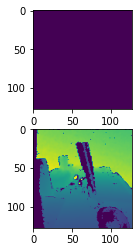

In [14]:
prds1 = np.reshape(preds[40], newshape=(preds[0].shape[0]*preds[0].shape[1]))
plt.subplot(2,1,1)
plt.imshow(np.reshape(prds1, newshape=(128, 128))*255)
plt.subplot(2,1,2)
plt.imshow(y_test[40]*255)